In [202]:
import json

import bz2
# import regex
from tqdm import tqdm
from scipy import sparse

In [203]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [204]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:50, 1822.44it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [205]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [206]:
data = pd.DataFrame(responses).dropna()[:1000]
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0


In [207]:
def lower(text):
    return text.lower()

In [208]:
data.text = data.text.apply(lower)

In [209]:
data.city = data.city.apply(lower)

In [210]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
14,г. москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"также как и многие давний клиент банка, был до...",2.0
19,г. москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,открыт вклад и счет в usd. плюс к этому есть з...,1.0
33,г. ростов-на-дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,доброго времени! вчера мне поступило смс-уведо...,1.0
76,г. санкт-петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
85,г. москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,для оплаты коммунальных платежей пользуюсь пла...,1.0


In [211]:
# количество отзывов в разных городах
data.city.value_counts()

г. москва                         482
г. санкт-петербург                103
г. нижний новгород                 17
г. екатеринбург                    17
г. ростов-на-дону                  15
                                 ... 
г. северск                          1
г. партизанск                       1
г. азов (ростовская обл.)           1
г. боровичи                         1
г. балаково (саратовская обл.)      1
Name: city, Length: 162, dtype: int64

In [212]:
# количество отзывов на разные банки
data.bank_name.value_counts()

Сбербанк России       222
ВТБ 24                 91
Альфа-Банк             66
Хоум Кредит Банк       44
Русский Стандарт       39
                     ... 
Внешпромбанк            1
Интерактивный Банк      1
Экспресс-Волга          1
Океан Банк              1
БФГ-Кредит              1
Name: bank_name, Length: 103, dtype: int64

In [213]:
l_symb = []
l_word = []
for response in data.text:
    l_symb.append(len(response))
    l_word.append(len(response.split()))

<AxesSubplot:>

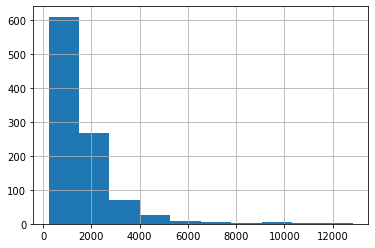

In [214]:
# гистограмма длин отзывов в символах
pd.Series(l_symb).hist()

<AxesSubplot:>

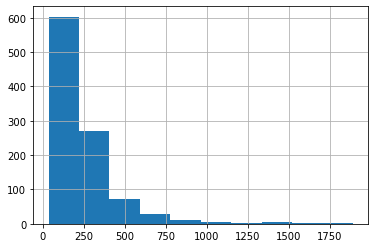

In [215]:
# гистограмма длин отзывов в словах
pd.Series(l_word).hist()

In [216]:
from nltk.tokenize import word_tokenize

In [217]:
from string import punctuation
from collections import Counter

In [218]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [219]:
corpus = [token for tweet in data.text for token in word_tokenize(tweet) if token not in punctuation]

In [220]:
len(corpus)

245382

In [221]:
# 10 самых частых слов
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 8839),
 ('и', 7052),
 ('не', 5659),
 ('на', 4827),
 ('что', 4299),
 ('я', 3792),
 ('с', 2949),
 ('по', 2387),
 ('мне', 2353),
 ('банка', 1986)]

In [222]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FED\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [223]:
from nltk.corpus import stopwords
# stopwords.words('russian')

In [224]:
noise = stopwords.words('russian') + list(punctuation) + ['``'] + ["''"] +['«'] + ['...'] + ['»']
# noise

In [225]:
# corpus_1 = [token for tweet in data.text for token in word_tokenize(tweet) if token not in noise]
corpus_1 = [token for token in corpus if token not in noise]

In [226]:
len(corpus_1)

157353

In [227]:
# 10 самых частых слов без стоп-слов
freq_dict_1 = Counter(corpus_1)
freq_dict_1.most_common(10)

[('банка', 1986),
 ('банк', 1214),
 ('это', 1198),
 ('деньги', 865),
 ('карту', 832),
 ('карты', 809),
 ('отделение', 594),
 ('заявление', 557),
 ('день', 515),
 ('дней', 475)]

In [228]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

In [229]:
def lemmatize(text):
    try:
        return " ".join(pymorphy2_analyzer.parse(word)[0].normal_form for word in text)
    except:
        return " "

In [230]:
corpus_2 = lemmatize(corpus_1).split()
# corpus_2

In [231]:
# 10 самых частых лемм
freq_dict_2 = Counter(corpus_2)
freq_dict_2.most_common(10)

[('банк', 4204),
 ('карта', 2530),
 ('это', 1296),
 ('день', 1254),
 ('сотрудник', 1191),
 ('деньга', 1171),
 ('отделение', 1166),
 ('мой', 1100),
 ('кредит', 1011),
 ('который', 1004)]

In [232]:
from ufal.udpipe import Model, Pipeline

In [233]:
model = Model.load("russian-ud-2.0-170801.udpipe")
model

<Swig Object of type 'model *' at 0x00000293BAA5D530>

In [234]:
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')
parsed = pipeline.process(' '.join(corpus_2))
# print(parsed)

In [235]:
corpus_3 = []
for string in parsed.split('\n'):
#     print(string)
    if 'NOUN' in string:
#         print(string.split('\t')[1])
        corpus_3.append(string.split('\t')[1])

In [236]:
len(corpus_3)

70600

In [237]:
# 10 самых частых существительных
freq_dict_3 = Counter(corpus_3)
freq_dict_3.most_common(10)

[('банк', 4247),
 ('карта', 2535),
 ('день', 1259),
 ('отделение', 1168),
 ('сотрудник', 1012),
 ('клиент', 987),
 ('деньга', 933),
 ('счёт', 852),
 ('заявление', 809),
 ('год', 731)]

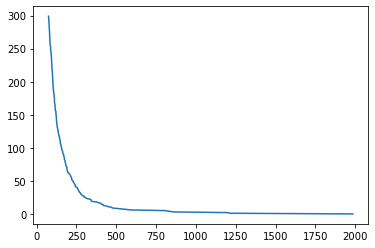

In [238]:
# кривая Ципфа
import matplotlib.pyplot as plt
%matplotlib inline

# freqs = list(freq_dict_3.values())
freqs = list(freq_dict_1.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [239]:
# кривая Хипса

In [240]:
cnt_1 = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(data.iterrows(), total = len(data)):
#     print(index, row)
    tokens = word_tokenize(row['text'])
    cnt_1.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt_1))
    n_tokens.append(sum(list(cnt_1.values())))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 223.35it/s]


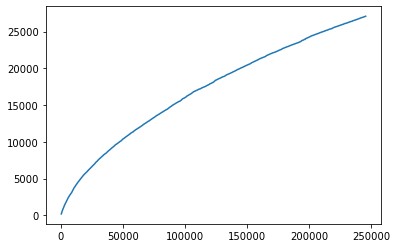

In [241]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

In [242]:
freq_dict_3['сотрудник']

1012

In [243]:
freq_dict_3['клиент']

987

In [244]:
freq_dict_3['мошенничество']

14

In [245]:
freq_dict_3['доверие']

6

In [246]:
# negative = data[data['rating_grade'] == 1]
# positive = data[data['rating_grade'] == 5]
positive = pd.DataFrame(responses).dropna()[pd.DataFrame(responses).dropna()['rating_grade'] == 5][:1000]
negative = pd.DataFrame(responses).dropna()[pd.DataFrame(responses).dropna()['rating_grade'] == 1][:1000]

In [247]:
import re
regex = re.compile("[А-Яа-я]+")
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

In [248]:
from nltk.corpus import stopwords
# mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
# noise = stopwords.words('russian') + list(punctuation)
def remove_stopwords(text, mystopwords = noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [249]:
def lemmatize(text):
    try:
        return " ".join(pymorphy2_analyzer.parse(word)[0].normal_form for word in text.split())
    except:
        return " "

In [250]:
%%time
positive.text = positive.text.apply(words_only)
positive.text = positive.text.apply(remove_stopwords)
positive.text = positive.text.apply(lemmatize)

Wall time: 38.4 s


In [251]:
# positive.text

In [252]:
%%time
negative.text = negative.text.apply(words_only)
negative.text = negative.text.apply(remove_stopwords)
negative.text = negative.text.apply(lemmatize)

Wall time: 41.2 s


In [253]:
# negative.text

In [254]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [255]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform(text for text in positive.text)
feature_names = tfidf.get_feature_names() 

In [256]:
tfidf_matrix.shape

(1000, 88859)

In [257]:
dense = tfidf_matrix.todense()

In [258]:
topic_id = 5

In [259]:
text = dense[topic_id].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)

In [260]:
tfidf_ranking = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)

In [261]:
# биграмы для положительных отзывов
rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,анна внимательно
1,весь внимание
2,внимание отнестись
3,выбрать хороший
4,выгода предложение
5,день буквально
6,документ результат
7,думать обрисовать
8,клиент ориентироваться
9,который думать


In [262]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform(text for text in negative.text)
feature_names = tfidf.get_feature_names() 

In [263]:
tfidf_matrix.shape

(1000, 102863)

In [264]:
dense = tfidf_matrix.todense()

In [265]:
topic_id = 5

In [266]:
text = dense[topic_id].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)

In [267]:
tfidf_ranking = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)

In [268]:
# биграмы для отрицательных отзывов
rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,бки информация
1,бки обновить
2,быть бки
3,висеть информация
4,выдать бумажка
5,говорить ипотека
6,звонить проверять
7,информация обновляться
8,исправить чужой
9,июнь какой


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [269]:
data = pd.DataFrame(responses).dropna()[:1000]

In [270]:
data.shape

(1000, 10)

In [271]:
%%time
data.text = data.text.apply(words_only)
data.text = data.text.apply(remove_stopwords)
data.text = data.text.apply(lemmatize)

Wall time: 40 s


In [272]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [273]:
texts = [text.split() for text in data.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [274]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [275]:
# %%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [276]:
sims.shape

(1000, 1000)

In [277]:
import seaborn as sns

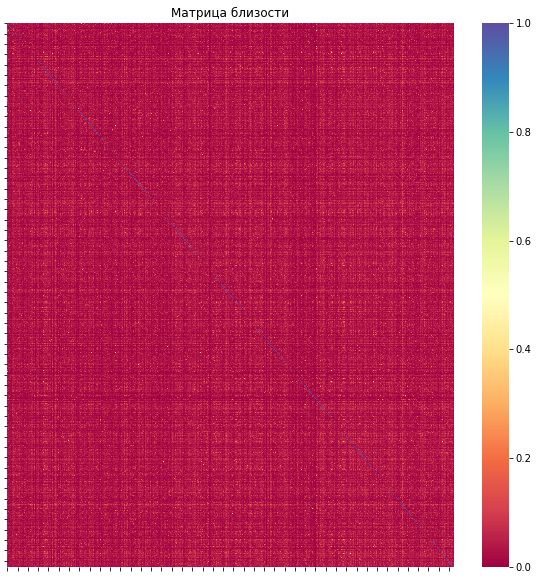

In [278]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [279]:
from gensim.models import lsimodel

In [280]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=50)

Wall time: 989 ms


In [281]:
lsi.show_topics(5)

[(0,
  '-0.174*"карта" + -0.133*"кредит" + -0.110*"деньга" + -0.109*"отделение" + -0.106*"заявление" + -0.104*"вклад" + -0.103*"счёт" + -0.099*"банкомат" + -0.099*"сбербанк" + -0.095*"сотрудник"'),
 (1,
  '0.370*"кредит" + 0.301*"страховка" + -0.301*"банкомат" + 0.287*"страхование" + -0.190*"карта" + 0.187*"договор" + 0.163*"погашение" + 0.147*"досрочный" + 0.126*"страховой" + -0.122*"деньга"'),
 (2,
  '0.482*"вклад" + -0.261*"банкомат" + 0.136*"ставка" + -0.133*"средство" + -0.130*"погашение" + -0.127*"платёж" + 0.121*"открыть" + -0.120*"зачислить" + -0.118*"чек" + -0.116*"денежный"'),
 (3,
  '-0.491*"вклад" + 0.181*"карта" + -0.151*"погашение" + -0.149*"счёт" + 0.143*"заявка" + -0.137*"досрочный" + -0.137*"договор" + -0.134*"средство" + 0.132*"страховка" + -0.117*"задолженность"'),
 (4,
  '-0.387*"банкомат" + -0.284*"страхование" + -0.269*"страховка" + 0.202*"задолженность" + -0.173*"вклад" + -0.163*"деньга" + -0.127*"чек" + 0.126*"платёж" + -0.126*"зачислить" + 0.120*"карта"')]

In [282]:
list_themes = ['сбербанк', 'втб', 'альфабанк', 'кредит', 'вклад']
for topic in lsi.show_topics():
    for theme in list_themes:
        if theme in words_only(str(topic)):
            print(words_only(str(topic)))
#     print(str(topic))
#     break

карта кредит деньга отделение заявление вклад сч т банкомат сбербанк сотрудник
карта кредит деньга отделение заявление вклад сч т банкомат сбербанк сотрудник
карта кредит деньга отделение заявление вклад сч т банкомат сбербанк сотрудник
кредит страховка банкомат страхование карта договор погашение досрочный страховой деньга
вклад банкомат ставка средство погашение плат ж открыть зачислить чек денежный
вклад карта погашение сч т заявка досрочный договор средство страховка задолженность
банкомат страхование страховка задолженность вклад деньга чек плат ж зачислить карта
карта банкомат страхование очередь кредит плат ж терминал услуга мы касса
сбербанк заявка заявление отделение г кредит банкомат смс проблема страховка
сбербанк заявка заявление отделение г кредит банкомат смс проблема страховка
терминал банкомат плат ж перевод заявление операция сч сч т звонок сбербанк
терминал услуга сбербанк оповещение карта смс заявка подключить лимит кредитный
терминал услуга сбербанк оповещение карта

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [283]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier

# # !!! На каждом этапе Pipeline нужно указать свои параметры
# # 1-ый вариант: tf-idf + LSI
# # 2-ой вариант: LDA

# # clf = Pipeline([
# #     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
# #     ('clf', RandomForestClassifier()),
# # ])



# clf = Pipeline([ 
#     ('vect', CountVectorizer()), 
#     ('tfidf', TfidfTransformer()), 
#     ('tm', TruncatedSVD()), 
#     ('clf', RandomForestClassifier())
# ])


In [284]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as mse

In [285]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [286]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [287]:
positive = pd.DataFrame(responses).dropna()[pd.DataFrame(responses).dropna()['rating_grade'] == 5]
negative = pd.DataFrame(responses).dropna()[pd.DataFrame(responses).dropna()['rating_grade'] == 1]

In [288]:
data_1 = pd.concat([positive, negative[:10511]], axis=0)

In [289]:
from sklearn.utils import shuffle
data_1 = shuffle(data_1)

In [290]:
data_1.text = data_1.text.apply(lower)
# data_1

In [291]:
data_1.rating_grade.value_counts()

1.0    10511
5.0    10511
Name: rating_grade, dtype: int64

In [292]:
x_train, x_test, y_train, y_test = train_test_split(data_1.text, data_1.rating_grade)

In [293]:
print(data_1.shape)
print(x_train.shape)
print(x_test.shape)

(21022, 10)
(15766,)
(5256,)


In [294]:
vec_1 = TfidfVectorizer(ngram_range=(1, 1))
bow_1 = vec_1.fit_transform(x_train)
clf_1 = RandomForestClassifier()
clf_1.fit(bow_1, y_train)
pred_1 = clf_1.predict(vec_1.transform(x_test))
print(classification_report(pred_1, y_test))

              precision    recall  f1-score   support

         1.0       0.97      0.92      0.94      2747
         5.0       0.91      0.96      0.94      2509

    accuracy                           0.94      5256
   macro avg       0.94      0.94      0.94      5256
weighted avg       0.94      0.94      0.94      5256



In [295]:
vec_2 = TfidfVectorizer(ngram_range=(2, 2))
bow_2 = vec_2.fit_transform(x_train)
clf_2 = RandomForestClassifier()
clf_2.fit(bow_2, y_train)
pred_2 = clf_2.predict(vec_2.transform(x_test))
print(classification_report(pred_2, y_test))

              precision    recall  f1-score   support

         1.0       0.96      0.88      0.92      2844
         5.0       0.87      0.96      0.91      2412

    accuracy                           0.92      5256
   macro avg       0.92      0.92      0.92      5256
weighted avg       0.92      0.92      0.92      5256



In [296]:
# результат чуть хуже

In [297]:
vec_3 = TfidfVectorizer(ngram_range=(3, 3))
bow_3 = vec_3.fit_transform(x_train)
clf_3 = RandomForestClassifier()
clf_3.fit(bow_3, y_train)
pred_3 = clf_3.predict(vec_3.transform(x_test))
print(classification_report(pred_3, y_test))

              precision    recall  f1-score   support

         1.0       0.77      0.87      0.82      2301
         5.0       0.89      0.80      0.84      2955

    accuracy                           0.83      5256
   macro avg       0.83      0.84      0.83      5256
weighted avg       0.84      0.83      0.83      5256



In [298]:
# еще хуже

In [299]:
vec_15 = TfidfVectorizer(ngram_range=(1, 5))
bow_15 = vec_15.fit_transform(x_train)
clf_15 = RandomForestClassifier()
clf_15.fit(bow_15, y_train)
pred_15 = clf_15.predict(vec_15.transform(x_test))
print(classification_report(pred_3, y_test))

              precision    recall  f1-score   support

         1.0       0.77      0.87      0.82      2301
         5.0       0.89      0.80      0.84      2955

    accuracy                           0.83      5256
   macro avg       0.83      0.84      0.83      5256
weighted avg       0.84      0.83      0.83      5256



In [300]:
# также

In [301]:
from sklearn.feature_extraction.text import CountVectorizer

In [302]:
clf_4 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=noise)), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=15)), 
    ('clf', RandomForestClassifier())
])

In [303]:
clf_4.fit(x_train, y_train)
pred_4 = clf_4.predict(x_test)
print(classification_report(pred_4, y_test))

              precision    recall  f1-score   support

         1.0       0.95      0.88      0.92      2826
         5.0       0.87      0.95      0.91      2430

    accuracy                           0.91      5256
   macro avg       0.91      0.92      0.91      5256
weighted avg       0.92      0.91      0.91      5256



In [304]:
# чуть хуже чем первый вариант

In [305]:
from sklearn.decomposition import LatentDirichletAllocation

In [306]:
clf_5 = Pipeline([ 
    ('vect', CountVectorizer(stop_words=noise)),
#     ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()), 
    ('tm', LatentDirichletAllocation(n_components=100)), 
    ('clf', RandomForestClassifier())
])

In [307]:
clf_5.fit(x_train, y_train)
pred_5 = clf_5.predict(x_test)
print(classification_report(pred_5, y_test))

              precision    recall  f1-score   support

         1.0       0.74      0.57      0.65      3380
         5.0       0.45      0.64      0.53      1876

    accuracy                           0.60      5256
   macro avg       0.60      0.61      0.59      5256
weighted avg       0.64      0.60      0.61      5256



In [308]:
# результат плохой, возможно надо подбирать гиперпараметры